<a href="https://colab.research.google.com/github/Cuzime/ASTRON-128/blob/main/ZTF_stamp_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! pip install ztfquery

In [5]:
! pip install photutils

In [6]:
from ztfquery import query
from astropy import time
import time as ttime

from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Get images between 2021-04-02 and 2022-04-02


In [7]:
zquery = query.ZTFQuery()
tstart = time.Time("2021-04-02").jd
tend = time.Time("2022-04-10").jd
#zquery.load_metadata(kind="raw", sql_query=f"obsjd BETWEEN {tstart} AND {tend} AND filtercode='zg' AND ccdid=8")
zquery.load_metadata(kind="raw", sql_query=f"obsjd BETWEEN {tstart} AND {tend}")

zquery.metatable

,infobits,field,ccdid,fid,filtercode,nid,expid,itid,imgtype,imgtypecode,...,exptime,seeing,airmass,moonillf,moonesb,telra,teldec,ccdrot,ipac_pub_date,ipac_gid
0,0,506,14,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
1,0,506,15,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
2,0,557,14,2,zr,1552,155212770,1,object,o,...,30,NaN,2.061,-0.750542,0,52.1240,18.95,0,2022-11-08 00:00:00+00,2
3,0,557,15,2,zr,1552,155212770,1,object,o,...,30,NaN,2.061,-0.750542,0,52.1240,18.95,0,2022-11-08 00:00:00+00,2
4,0,606,2,2,zr,1552,155212817,1,object,o,...,30,NaN,2.185,-0.750542,0,46.1153,26.15,0,2022-11-08 00:00:00+00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008444,0,645,10,2,zr,1924,192451997,1,object,o,...,30,NaN,2.016,0.523383,0,338.3850,26.15,0,2022-07-07 00:00:00+00,1
2008445,0,645,11,2,zr,1924,192451997,1,object,o,...,30,NaN,2.016,0.523383,0,338.3850,26.15,0,2022-07-07 00:00:00+00,1
2008446,0,645,12,2,zr,1924,192451997,1,object,o,...,30,NaN,2.016,0.523383,0,338.3850,26.15,0,2022-07-07 00:00:00+00,1
2008447,0,645,13,2,zr,1924,192451997,1,object,o,...,30,NaN,2.016,0.523383,0,338.3850,26.15,0,2022-07-07 00:00:00+00,1


In [16]:
# set size of stamps
size = 256
step = int(size/2)

def get_image(file_path, quad):
    hdu_1 = fits.open(file_path)
    image_data = hdu_1[quad].data
    hdu_1.close()

    return image_data

def get_stamps(image):
    # get image dimensions
    naxis1,naxis2 = np.shape(image)
    x_centers = np.arange(step, naxis1-step, step)
    y_centers = np.arange(step, naxis2-step, step)
    stamps = []
    for x_center in x_centers:
        for y_center in y_centers:
            stamp = image[y_center-step:y_center+step, x_center-step:x_center+step]
            stamps.append(stamp)

    stamps = np.array(stamps)

    return stamps.reshape(stamps.shape[0], stamps.shape[1], stamps.shape[2], 1)

def visual_transform_image(image):
    # VISUALIZE THE DATA

    # Scale the image based on its percentiles
    interval = PercentileInterval(99.5)
    vmin, vmax = interval.get_limits(image)
    norm = plt.Normalize(vmin, vmax)

    # Apply an asinh stretch to enhance faint features
    stretch = AsinhStretch()
    scaled_data = stretch(norm(image))

    return scaled_data

In [9]:
index_list = np.random.randint(0, len(zquery.metatable), size = 100)
np.random.shuffle(index_list)
urls, locations = zquery.download_data(suffix="test.fits", source="local", download_dir=None,
                                          show_progress=True, nodl=True, indexes=index_list, overwrite = True)
print(urls[0][28:])
print(urls[0])

ztf_20210704235347_000582_zg_c16_o.fits.fz
./Data/raw/2021/0704/235347/ztf_20210704235347_000582_zg_c16_o.fits.fz


In [ ]:
import PIL
from PIL import Image

In [10]:
folder_path = '/Users/andrewgoh/Desktop/NDC/ZTF_images/'
folder_path = '/content/drive/MyDrive/ZTF_images/'
file_list = os.listdir(folder_path)
print(file_list)
print(len(file_list))

['ztf_20220829250856_000240_zg_c10_o.fits.fz', 'ztf_20210904292187_000240_zr_c10_o.fits.fz', 'ztf_20190104522836_000268_zr_c03_o.fits.fz', 'ztf_20221011149028_000240_zr_c10_o.fits.fz', 'ztf_20190612242269_000875_zr_c07_o.fits.fz', 'ztf_20190606264259_000875_zr_c07_o.fits.fz', 'ztf_20200226240660_000819_zr_c08_o.fits.fz', 'ztf_20181229539352_001576_zr_c08_o.fits.fz', 'ztf_20210101352188_001253_zg_c09_o.fits.fz', 'ztf_20201012515197_001253_zr_c09_o.fits.fz', 'ztf_20201110476655_001253_zg_c09_o.fits.fz', 'ztf_20181120418345_001253_zr_c09_o.fits.fz', 'ztf_20210219521331_000226_zr_c09_o.fits.fz', 'ztf_20220513252315_000226_zg_c09_o.fits.fz', 'ztf_20220605229433_000226_zr_c09_o.fits.fz', 'ztf_20220523229248_000226_zg_c09_o.fits.fz', 'ztf_20220603229942_000226_zr_c09_o.fits.fz', 'ztf_20210609211921_000226_zg_c09_o.fits.fz', 'ztf_20210527250683_000226_zg_c09_o.fits.fz', 'ztf_20210809451146_001545_zi_c16_o.fits.fz', 'ztf_20190804458333_001545_zg_c16_o.fits.fz', 'ztf_20210902413507_001545_zi_c16

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
from sklearn.preprocessing import PowerTransformer
import random
import math
import keras
import os
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from sklearn.preprocessing import StandardScaler

''

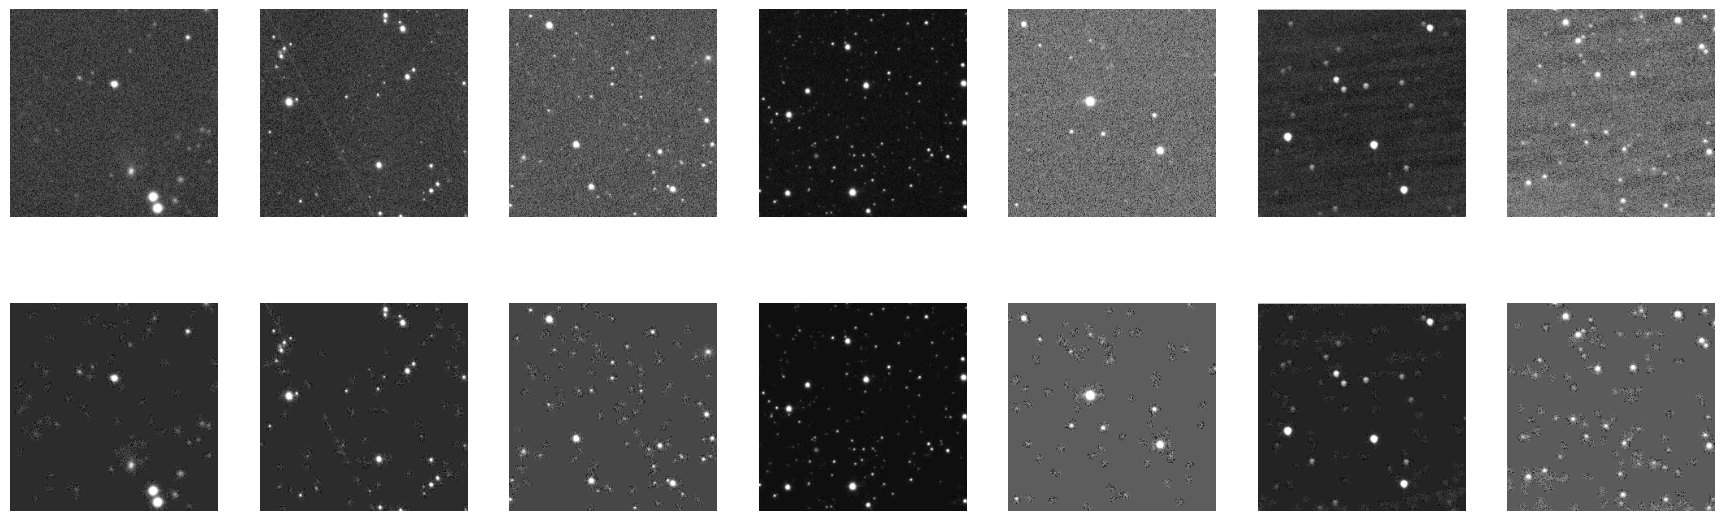

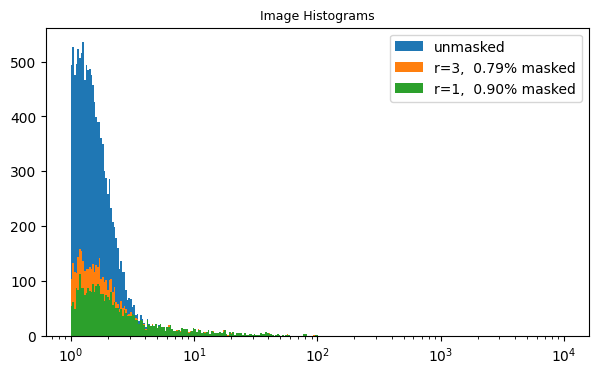

In [78]:
from astropy.visualization import SqrtStretch, AsinhStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

def rescale_astronomical_image(image, bkg_sigma=3.0,
                               window=(50,50),
                               filter_size=(3,3),
                               maxiters=10,
                               npixels=10,
                               radius=3):
    """Rescale an image based on the noise
       See https://photutils.readthedocs.io/en/stable/background.html#sigma-clipping-sources
    """

    # First, estimate the background image
    sigma_clip = SigmaClip(sigma=bkg_sigma)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, window, filter_size=filter_size,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

    # subtract off the background
    new_im = image - bkg.background

    # mask sources and get the stats
    sigma_clip = SigmaClip(sigma=bkg_sigma, maxiters=maxiters)
    threshold = detect_threshold(new_im, nsigma=bkg_sigma-2, sigma_clip=sigma_clip)
    segment_img = detect_sources(new_im, threshold, npixels=npixels)
    footprint = circular_footprint(radius=radius)
    mask = segment_img.make_source_mask(footprint=footprint)
    _, median, std = sigma_clipped_stats(new_im, sigma=bkg_sigma, mask=mask)

    # Rescale
    new_im -= median
    new_im /= std

    return new_im, mask, median, std

# random image
index = random.randint(0, len(file_list)-1)
quad = random.randint(1, 4)

#index = 12
#quad = 1

plt.figure(figsize = (22,7))

for i in range(7):

    # random image
    index = random.randint(0, len(file_list)-1)
    quad = random.randint(1, 4)

    #index = 12
    #quad = 1

    file_path = '/content/drive/MyDrive/ZTF_images/' + file_list[index]
    image = get_image(file_path, quad)

    # get stamps
    stamps = get_stamps(image)
    idx = random.randint(0, len(stamps)-1)
    #idx = 339

    my_stamp = stamps[idx]

    visual_stamp = visual_transform_image(my_stamp)
    #plt.figure(figsize = (7,7))
    #plt.title('original stamp')
    #plt.imshow(visual_stamp.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')
    #plt.colorbar()
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(visual_stamp.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')

    plt.axis('off')

    # rescale and mask
    im, mask, median, std  = rescale_astronomical_image(stamps[idx].reshape(stamps.shape[1], stamps.shape[2]))
    visual_im = visual_transform_image(im)

    im_masked = im*mask
    visual_im_masked = visual_transform_image(im_masked)

    #plt.figure(figsize = (7,7))
    #plt.title('scaled stamp and masked')
    #plt.imshow(visual_im_masked.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')
    #plt.colorbar()

    ax = plt.subplot(2,7, i+8)
    plt.imshow(visual_im_masked.reshape(stamps.shape[1], stamps.shape[2]), cmap = 'gray')
    plt.axis('off')


bins = 10**(np.linspace(0,4,300))
fig = plt.figure(figsize=(7,4))
im_flat = im.flatten()
plt.hist(im_flat, bins = bins, label = 'unmasked')
plt.title('Image Histograms', fontsize=9)
plt.xscale('log')

im, mask, median, std  = rescale_astronomical_image(stamps[idx].reshape(stamps.shape[1], stamps.shape[2]), radius = 3)
im_masked = im*mask

#fig = plt.figure(figsize=(13,4))
im_masked_flat = im_masked.flatten()
num_masked = list(im_masked_flat).count(np.median(im_masked_flat))
perc=num_masked/len(im_masked_flat)

plt.hist(im_masked_flat, bins = bins, label = f'r=3,  {perc:.2f}% masked')
#plt.title('Image masked Histogram, r = 3', fontsize=9)
plt.xscale('log')

num_masked = list(im_masked_flat).count(np.median(im_masked_flat))
#print(num_masked/len(im_masked_flat))

im, mask, median, std  = rescale_astronomical_image(stamps[idx].reshape(stamps.shape[1], stamps.shape[2]), radius = 1)
im_masked = im*mask

#fig = plt.figure(figsize=(13,4))
im_masked_flat = im_masked.flatten()
num_masked = list(im_masked_flat).count(np.median(im_masked_flat))
perc=num_masked/len(im_masked_flat)
plt.hist(im_masked_flat, bins = bins, label = f'r=1,  {perc:.2f}% masked')
#plt.title('Image masked Histogram, r = 1', fontsize=9)
plt.xscale('log')

plt.legend()




"""print('unmasked min:', np.min(im_flat))
print('unmasked median:', np.median(im_flat))
print('unmasked max:', np.max(im_flat))

print('masked min:', np.min(im_masked_flat))
print('masked median:', np.median(im_masked_flat))
print('masked max:', np.max(im_masked_flat))"""

''

In [ ]:
count = 0
for i in range(1000):
  start = ttime.time()
  # get random indexes from zquery.metatable
  index_list = np.random.randint(0, len(zquery.metatable), size = 20)

  # DOWNLOAD DATA INTO LOCAL DIRECTORY
  urls, locations = zquery.download_data(suffix="test.fits", source="local", download_dir=None,
                                          show_progress=True, nodl=True, indexes=index_list, overwrite = True)
  zquery.download_data("test.fits", nprocess=20, show_progress=True, indexes=index_list)
  end = ttime.time()
  print(end-start)
  # FOR EACH URL/IMAGE make one normalized stamp
  start = ttime.time()
  for url in urls:
    file_path = url
    file_name = url[28:]
    quad = 1

    # get image
    image_data = get_image(file_path, quad)

    """# log10 scale image
    interval = MinMaxInterval()
    vmin, vmax = interval.get_limits(image_data)
    image_log = np.log10(image_data-vmin+1)"""

    # GET STAMPS of log scaled image and get random stamp
    stamps = get_stamps(image_data)
    stamp_idx = np.random.randint(0,len(stamps)-1)




    image = np.array(stamps[stamp_idx]).astype(np.float16)
    # SAVE SINGLE STAMP
    np.save('/content/drive/MyDrive/ZTFquerystamps4/' + file_name[:-8],image)

  end = ttime.time()
  print(end-start)
  shutil.rmtree('./Data')

  count += 1
  print(count)



11.682610273361206
9.417710065841675
1
13.427998542785645
9.360430479049683
2
12.22696328163147
9.351077795028687
3
8.416959047317505
9.43639349937439
4
16.740180492401123
9.416038513183594
5
13.157167673110962
9.451643943786621
6
13.7938711643219
9.43977975845337
7
10.4667329788208
9.355164289474487
8
12.489478588104248
9.398864030838013
9
11.424910068511963
9.430636644363403
10
17.359516143798828
9.450852394104004
11
11.692988634109497
9.503693103790283
12
7.214454889297485
9.582974195480347
13
5.382608652114868
9.463771104812622
14
16.579034328460693
9.562187194824219
15
15.368705749511719
9.521370649337769
16
19.713552474975586
9.53728985786438
17
10.883307933807373
9.39799165725708
18
11.206544876098633
9.462053775787354
19
14.412862062454224
9.45100212097168
20
11.999554634094238
9.380181312561035
21
11.605384111404419
9.458022356033325
22
8.790545463562012
9.457512140274048
23
7.481074094772339
9.519654989242554
24
13.132752418518066
9.55489993095398
25
13.445688962936401
9.5407

In [ ]:
# check ZTFquerystamps list
"""folder_path_1 = '/content/drive/MyDrive/ZTFquerystamps'
file_list_1 = os.listdir(folder_path_1)
#print(file_list_1)
print(len(file_list_1))

folder_path_2 = '/content/drive/MyDrive/ZTFquerystamps2'
file_list_2 = os.listdir(folder_path_2)
#print(file_list_2)
print(len(file_list_2))"""

folder_path_3 = '/content/drive/MyDrive/ZTFquerystamps3'
file_list_3 = os.listdir(folder_path_3)
#print(file_list_2)
print(len(file_list_3))



folder_path_test = '/content/drive/MyDrive/ZTFquerystampstest'
file_list_test = os.listdir(folder_path_test)
print(len(file_list_test))

17244
5893


In [ ]:
import time

def generate_train_stamps_ZTFquery(batch_size):
  while True:
    counter = 0
    stamp_list = []
    for i in range(len(file_list_3)):
      if (counter == batch_size):
        counter = 0
        yield np.array(stamp_list)
        stamp_list = []

      file_path = folder_path_3 + '/' + file_list_3[3]
      image_data = np.load(file_path)
      stamp_list.append(image_data)
      counter += 1

gen = generate_train_stamps_ZTFquery(64)

start = time.time()
for i in range(10):
  stamps = next(gen)
end = time.time()
print(end-start)

print(np.shape(stamps))
#plt.imshow(stamps[0].reshape(256,256),cmap = 'gray')

0.7228753566741943
(64, 256, 256, 1)


In [ ]:
import shutil

shutil.rmtree('./Data')


(256, 256, 1)


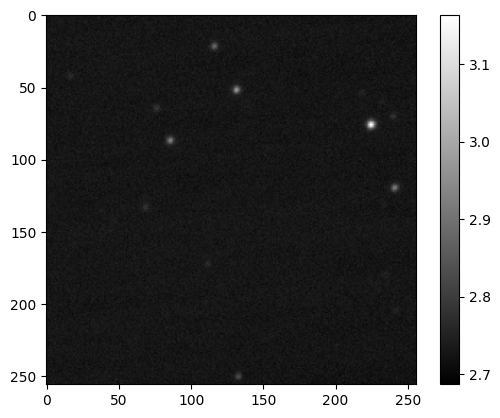

In [ ]:
# check out some stamps in ZTFquerystamps

idx = np.random.randint(0, len(file_list)-1)
path = folder_path + '/' + file_list[idx]
hdu_1 = fits.open(path)
image_data = hdu_1[0].data
hdu_1.close()

print(np.shape(image_data))
plt.imshow(image_data.reshape(256,256), cmap = 'gray')
plt.colorbar()